# Projet 10 : Détectez des faux billets avec Python

Mon entreprise, spécialisé dans la data, a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM). Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros.

Le but du projet est de mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets. Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.

La mission se déroulera en plusieurs étapes :

- Nettoyage des données
- Traitement des valeurs manquantes avec la régression linéaire
- Exploration (analyses univariées, matrice de corrélation, test d'hypothèse)
- Création du modèle de Régression Logistique et de la courbe ROC
- Kmeans
- Validation du modèle
- Création de la fonction de prédiction

## Sommaire<a id='sommaire'></a>
<ol><li><a href="#nettoyage">Nettoyage et Analyse</a></li>
        <ol>
            <li><a href="#reglineaire">Traitement des valeurs manquantes avec la régression linéaire</a></li>
        </ol>
    <li><a href="#exploration">Exploration</a></li> 
        <ol>
            <li><a href="#univar">Analyses univariées</a></li>
            <li><a href="#testhyp">Test d'hypothèse</a></li>
        </ol>
    <li><a href="#modelisation">Modélisation</a></li> 
        <ol>
            <li><a href="#reglogsklearn">Régression Logistique avec sklearn</a></li>
            <li><a href="#reglogstatmodel">Régression Logistique avec statmodels</a></li>
            <li><a href="#kmeans">Kmeans</a></li>
        </ol>
    <li><a href="#evalfinal">Evaluation finale</a></li> 
        <ol>
            <li><a href="#fonctpred">Fonction de prédiction</a></li>
        </ol>
</ol>

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
from functions import backward_selected

In [3]:
from scipy.stats import levene, ttest_ind, shapiro, bartlett
from scipy.spatial.distance import mahalanobis
import scipy.stats as st

In [4]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [7]:
folder = 'D:/Data_Analyst_Projet/Projet 10/Données/'

In [8]:
data = pd.read_csv(folder+'billets.csv', delimiter=';')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# Plan

1. Identification de la problématique
    - identification de la variable cible
    - identification des métriques d'évaluation, R², matrice de confusion, classification report...
    - objectif de score pour chacune de ces métriques  

<br>

2. Nettoyage
    - gestion des valeurs manquantes, utiliser la régression linéaire (sur quelle variable ?) --> faire une regression multiple sur la variable ou il y a des valeurs manquantes (sans les valeurs manquantes) puis faire une prédiction pour les valeurs manquantes
    - gestion des valeurs aberrantes
    - compréhension du dataset

<br>

3. Exploration
    - compréhension du dataset
    - analyse des corrélations : matrice de corrélations, heatmap
    - analyse des variables par rapport à la variable cible
    - analyses univariées : boxplot et histogramme pour chaque variable qualitative
    - analyses bivariées : quantitatif/qualitatif --> analyse des variables par groupes
        conclusion rapide à chaque fois --> essayer de trouver des pistes
    - analyses bivariées quantitatif/quantitatif --> voir les corrélations
    - si je vois quelque chose --> verifier la signicativité avec un test statistique
        student...  
      
<br>

5. Modélisation
    - Choix des algos : Régression logistique ou ACP + Kmeans
    - Regression logistique --> expliquer les principes de la régression logistique, revoir les prérequis
          - Standardisation des données ? / polynomiales features ?
          - vérifier que les donnees respectent les prérequis de la régression logistique
    - ACP + Kmeans --> voir etapes projet precedent + github
    - créer jeu entrainement, validation, test
    - utiliser cross validation
    - utiliser gridsearchcv --> optimisation des hyperparamètres
    
<br> 
  
6. Evaluation du modèle 
    - learning curve
    - confusion matrix
    - R²
    - classification report

### Quelques définitions : 

<br> 

Bonne réponse du modèle :

    Vrais positifs  : le billet est vrai et le modèle indique que le billet est vrai

    Vrais négatifs  : le billet est faux et le modèle indique que le billet est faux
    

Mauvaise réponse du modèle :

    Faux négatifs : le billet est vrai et le modèle indique que le billet est faux

    Faux positifs : le billet est faux et le modèle indique que le billet est vrai

Précision : TP / (TP + FP)

    Taux de vrais positifs parmis toutes les observations classées vraies par le modèle

Recall ou sensibilité : TP / (TP + FN)

    Taux de vrais positifs, taux de vrais bien classés par le modèle
    
Spécificité : TN / (FP + TN):

    Taux de vrais négatifs, taux de faux bien classés par le modèle

F1 score = 2*(precision * recall) / (precision + recall)

    Mesure global du modèle

<a id='nettoyage' ></a>
# Nettoyage et Analyse<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [10]:
data['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

1000 vrais billets et 500 faux billets.

In [11]:
data[data.isna().any(axis=1)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [12]:
data[data.isna().any(axis=1)].shape

(37, 7)

Il y 37 valeurs manquantes sur 1500 lignes, uniquement pour la variable margin_low.

Nous allons les traiter en faisant une régression linéaire multiple en prenant margin_low comme variable cible, et en prédisant les valeurs où elles sont manquantes.

In [13]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


<a id='reglineaire' ></a>
## Traitement des valeurs manquantes avec la régression linéaire<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

Nous allons traiter les valeurs manquantes de la variable margin_low en imputant par régression linéaire.  
Nous allons faire de margin_low la variable cible 'y' et des autres variables X les variables explicatives.

Nous allons entrainer le modèle de régression linéaire sur les données, trouver un modèle (une équation), qui fait le lien entre X et y puis généraliser le modèle sur de nouvelles données.

Nous ferons ensuite des prédictions pour imputer les données manquantes.

### Explication de la Régression linéaire simple

#### Principe de base

La régression linéaire simple permet d'expliquer, de manière linéaire, une variable Y(variable à expliquer), aléatoire en fonction d'une variable explicative X

(on la nomme parfois régresseur ou covariable).

Le modèle de régression linéaire simple suppose, comme son nom l'indique, qu'il existe une relation linéaire entre la variable à expliquer et la variable explicative :
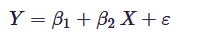

Mathématiquement, on considère que :

Y est une variable aléatoire, observable ;

X est une variable déterministe (non aléatoire), observable ;

β1 et β2 sont des paramètres inconnus (non observables) ;

ε est une variable aléatoire centrée (autour de 0) de variance σ2 inconnue (c'est également un paramètre du modèle).

L'objectif est de déterminer, d'estimer les paramètres de la droite de régression : l'ordonnée à l'origine β1
et le coefficient directeur β2 .

#### Méthode des Moindres Carrés Ordinaire

Pour estimer β1 et β2, on utilise la méthode des moindres carrés ordinaire.  

On va chercher à minimiser la somme des carrés des résidus :
    
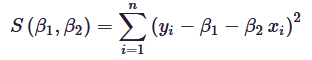

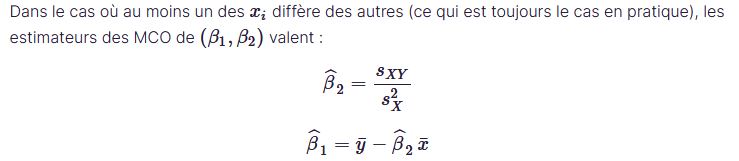

#### Coefficient de détermination

C'est le taux de variation expliqué par le modèle.

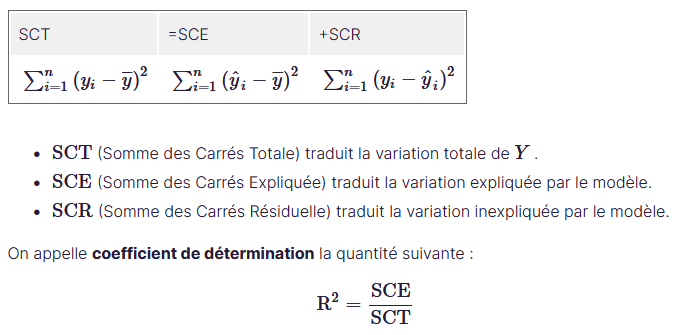

### Explication modèle de régression multiple

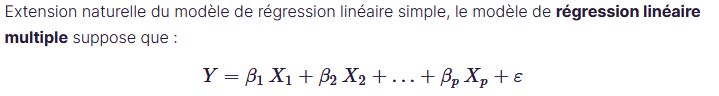
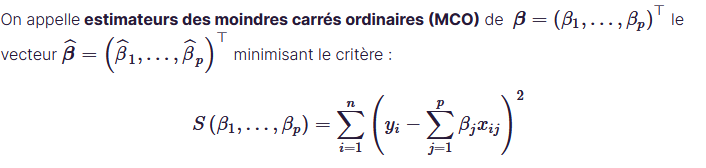
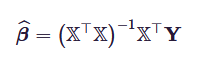
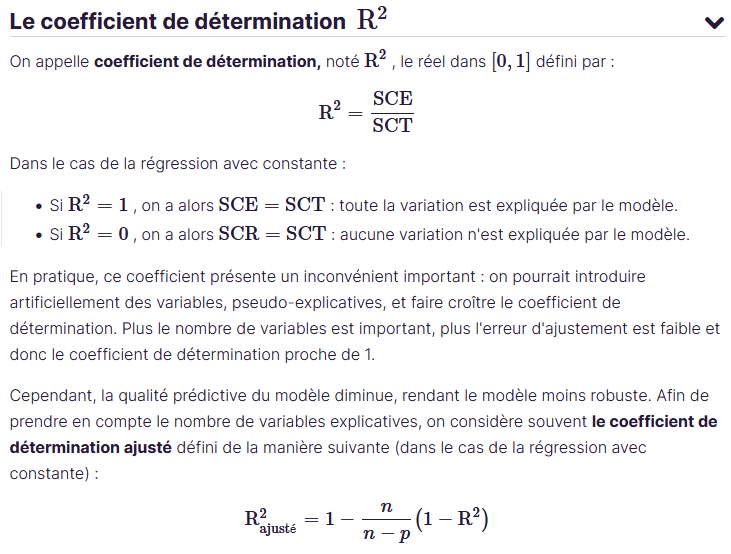

### Modèle de régression linéaire multiple

In [14]:
# data sans les valeurs manquantes
df = data.dropna()
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [15]:
# variables cible et expliquées
X = df.drop(columns=['is_genuine', 'margin_low'])
y = df['margin_low']

J'enlève la variable 'is_genuine' car c'est la variable cible du modèle final.  
Or, il ne serait pas rigoureux de l'utilisé en variable explicative dans un premier temps, puis en variable cible dans un second temps, cela créerait un biais et rendrait le modèle dépendant de la variable qu'il essait de prédire.

In [16]:
# encodage de la variable binaire
#X['is_genuine'] = X['is_genuine'].replace([True, False], [1,0])

In [17]:
# creation des jeux d'entrainement et de test
# pas forcément nécessaire pour de l'imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
# creation du modèle de régression linéaire
model = LinearRegression()

model.fit(X, y)

model.score(X, y)

0.4773366973063957

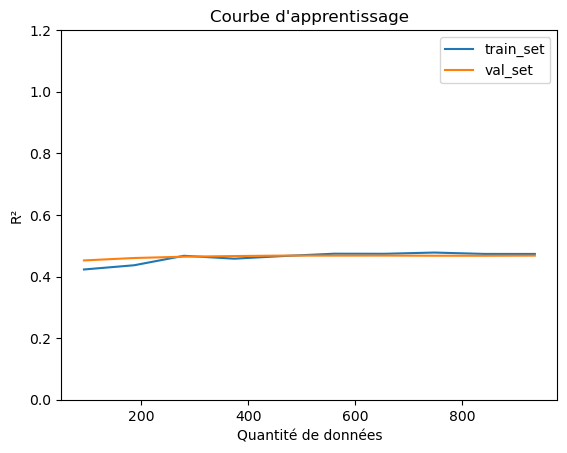

In [19]:
# courbe d'apprentissage du meilleur estimateur
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

In [20]:
# données à prédire
donnees_manquantes = data[data.isna().any(axis=1)].drop(columns=['is_genuine', 'margin_low'])
donnees_manquantes.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [21]:
# index données manquantes à prédire
donnees_manquantes_index = donnees_manquantes.index

In [22]:
# prediction des valeurs manquantes dans margin_low selon notre modèle
prediction_donnees_manquantes = model.predict(donnees_manquantes)
prediction_donnees_manquantes

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [23]:
# imputation des données manquantes par nos prédictions
data.loc[data.isna().any(axis=1),'margin_low'] = prediction_donnees_manquantes

In [24]:
data[data.isna().any(axis=1)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [25]:
# données billets avec les données prédites pour margin_low
data.loc[donnees_manquantes_index].head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36


## Régression multiple statsmodels

Je recommence avec statsmdodels, pour comparer les 2 modèles, vérifier que toutes variables sont significatives pour la régression linéaire multiple, vérifier que les résidus suivent une loi normale et vérifier la colinéarité des variables avec les VIF.

In [26]:
X_sm = sm.add_constant(X)

# creation des jeux d'entrainement et de test
# pas nécessaire pour l'imputation, autant donner le maximum de données au modèle
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results = sm.OLS(y, X_sm).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 24 Oct 2023   Prob (F-statistic):          2.60e-202
Time:                        14:13:17   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# nouvelles données manquantes pour faire les prédictions avec statsmodels, ajout de la colonne de biais
donnees_manquantes_sm = sm.add_constant(donnees_manquantes)
donnees_manquantes_sm.head()

,const,diagonal,height_left,height_right,margin_up,length
72,1.0,171.94,103.89,103.45,3.25,112.79
99,1.0,171.93,104.07,104.18,3.14,113.08
151,1.0,172.07,103.80,104.38,3.02,112.93
197,1.0,171.45,103.66,103.80,3.62,113.27
241,1.0,171.83,104.14,104.06,3.02,112.36


In [28]:
# comparaison predictions des 2 modèles
df_compar_model = pd.DataFrame()
df_compar_model['pred_sm'] = results.predict(donnees_manquantes_sm)
df_compar_model['pred_sklearn'] = model.predict(donnees_manquantes)
df_compar_model

,pred_sm,pred_sklearn
72,4.318525,4.318525
99,4.393668,4.393668
151,4.410457,4.410457
197,4.319014,4.319014
241,4.650617,4.650617
251,3.803308,3.803308
284,4.179736,4.179736
334,4.127442,4.127442
410,4.135034,4.135034
413,4.160539,4.160539


Les résultats sont identiques.

### Vérification de la normalité des résidus

In [29]:
shapiro(results.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

D'après le test de Shapiro, les résidus ne suivent pas une loi normale.  
Cependant, l'histogramme qui suit à l'allule d'une courbe de Gauss, de plus la régression multiple à un objectif d'imputation.  
Elle est donc acceptée ici.

<Axes: ylabel='Count'>

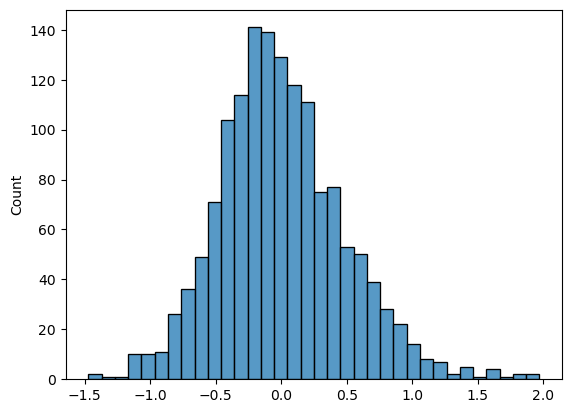

In [30]:
sns.histplot(results.resid)

### Vérification des VIF

On calcul des VIF pour vérifier que les variables ne s'influencent pas entre elles.

In [31]:
vif = [variance_inflation_factor(X_sm, i) for i in range(X_sm.shape[1])]
df_vif = pd.DataFrame(vif, index=X_sm.columns, columns=['VIF'])
df_vif

,VIF
const,590198.238883
diagonal,1.013613
height_left,1.138261
height_right,1.230115
margin_up,1.404404
length,1.576950


Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

<a id='exploration' ></a>
# Exploration<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

<a id='univar' ></a>
## Analyses univariées<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [32]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### Répartition des variables explicatives pour les vrais et les faux billets

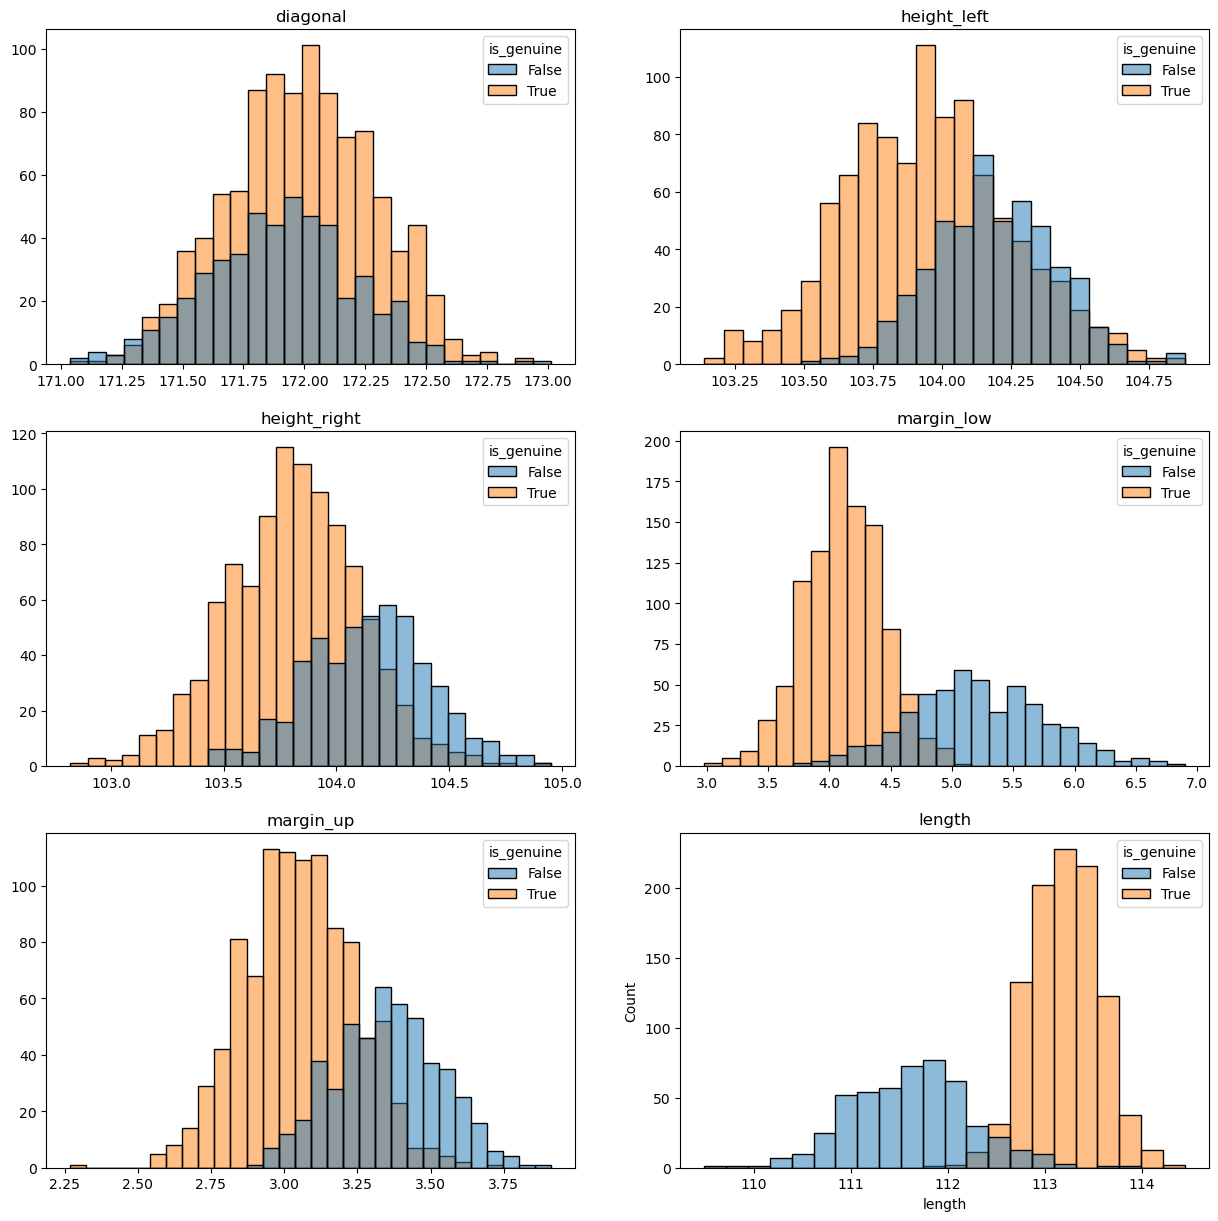

In [33]:
nb_col = data.drop(columns='is_genuine').shape[1]

plt.figure(figsize=(15, 20))

for col, i in zip(data.drop(columns='is_genuine').columns, range(nb_col)):
    plt.xlabel(None)
    plt.ylabel(None)
    plt.subplot(1+nb_col//2, 2, i+1)
    plt.title(col)
    sns.histplot(data=data, x=col, hue='is_genuine')

Il semblerait que les distributions soient normales pour toutes les variables pour les vrais et faux billets.

Il semblerait aussi que les valeurs des variables soient significativement différentes pour les vrais et faux billets pour toutes les variables à part la variable 'diagonal'.

Les différences sont particulièrement marquées pour les variables margin_low, margin_up et length.

In [34]:
data.drop(columns='is_genuine').columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

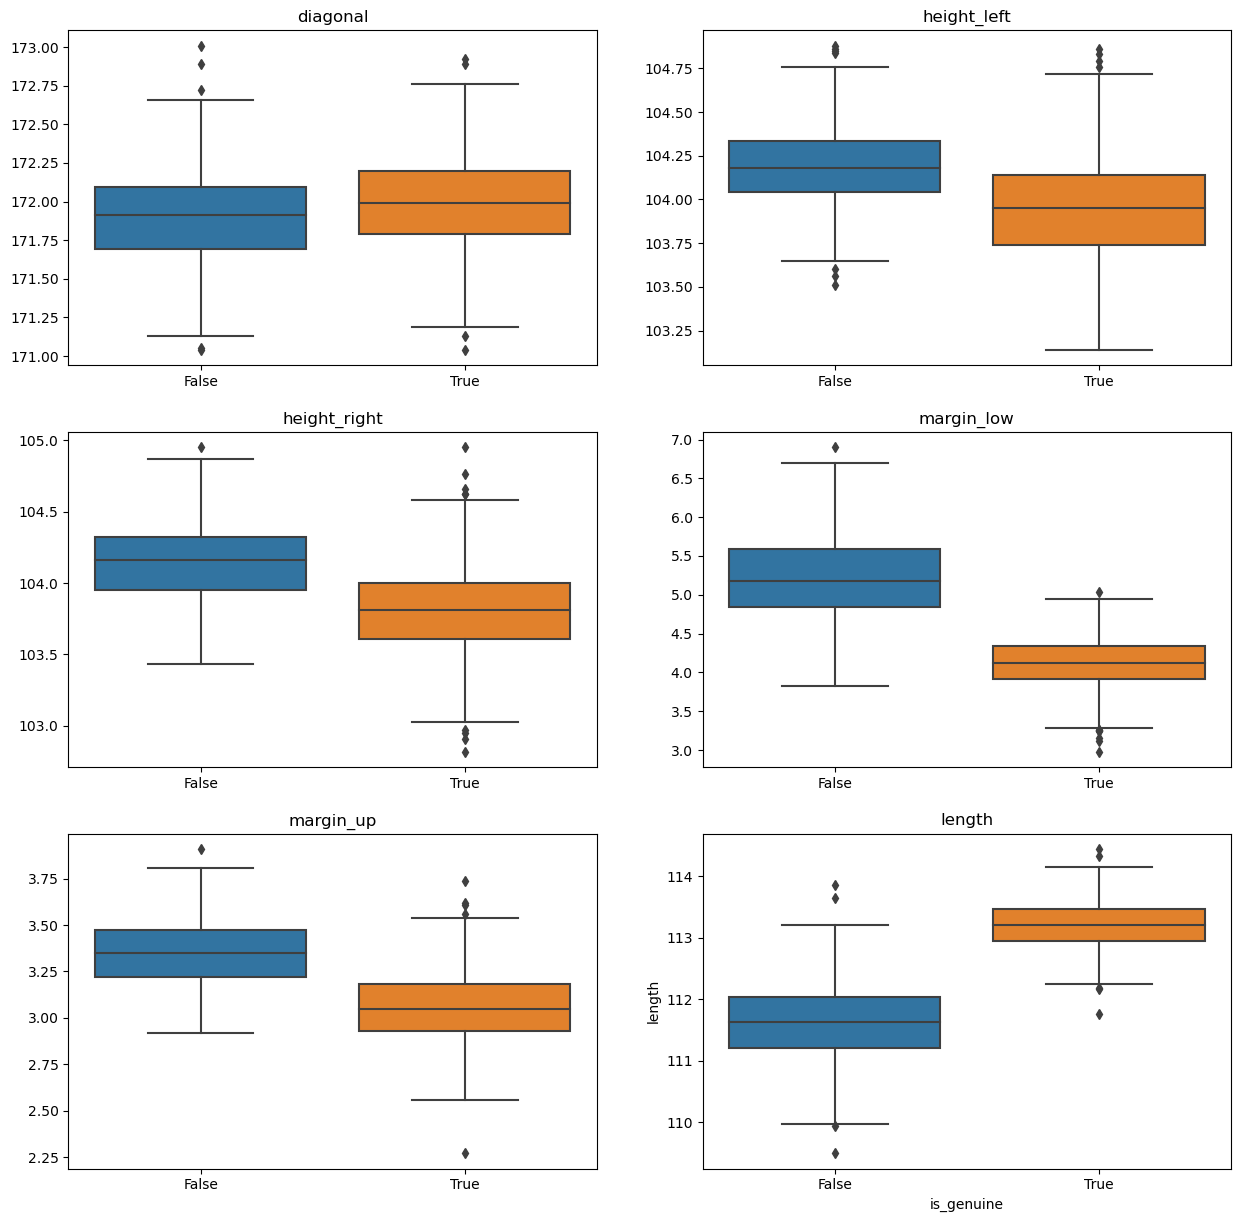

In [35]:
nb_col = data.drop(columns='is_genuine').shape[1]

plt.figure(figsize=(15, 20))

for col, i in zip(data.drop(columns='is_genuine').columns, range(nb_col)):
    plt.xlabel(None)
    plt.ylabel(None)
    plt.subplot(1+nb_col//2, 2, i+1)
    plt.title(col)
    sns.boxplot(data=data, y=col, x='is_genuine')

<Axes: >

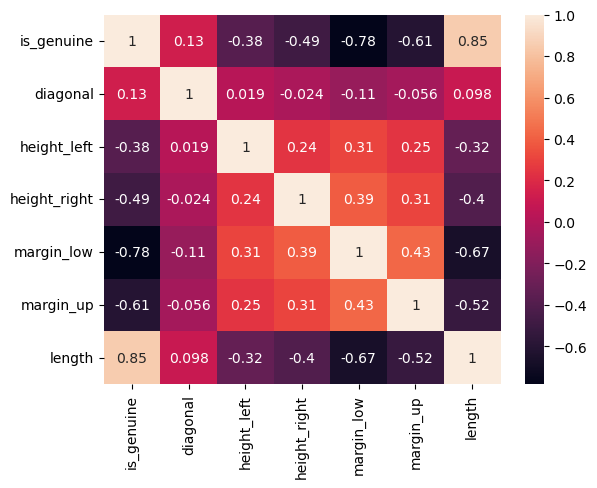

In [36]:
# matrice de corrélations
sns.heatmap(data.corr(), annot=True)

Cela confirme l'hypothèse du dessus, se sont surtout les variables margin_low, margin_up et length qui sont corrélées à la variable cible.

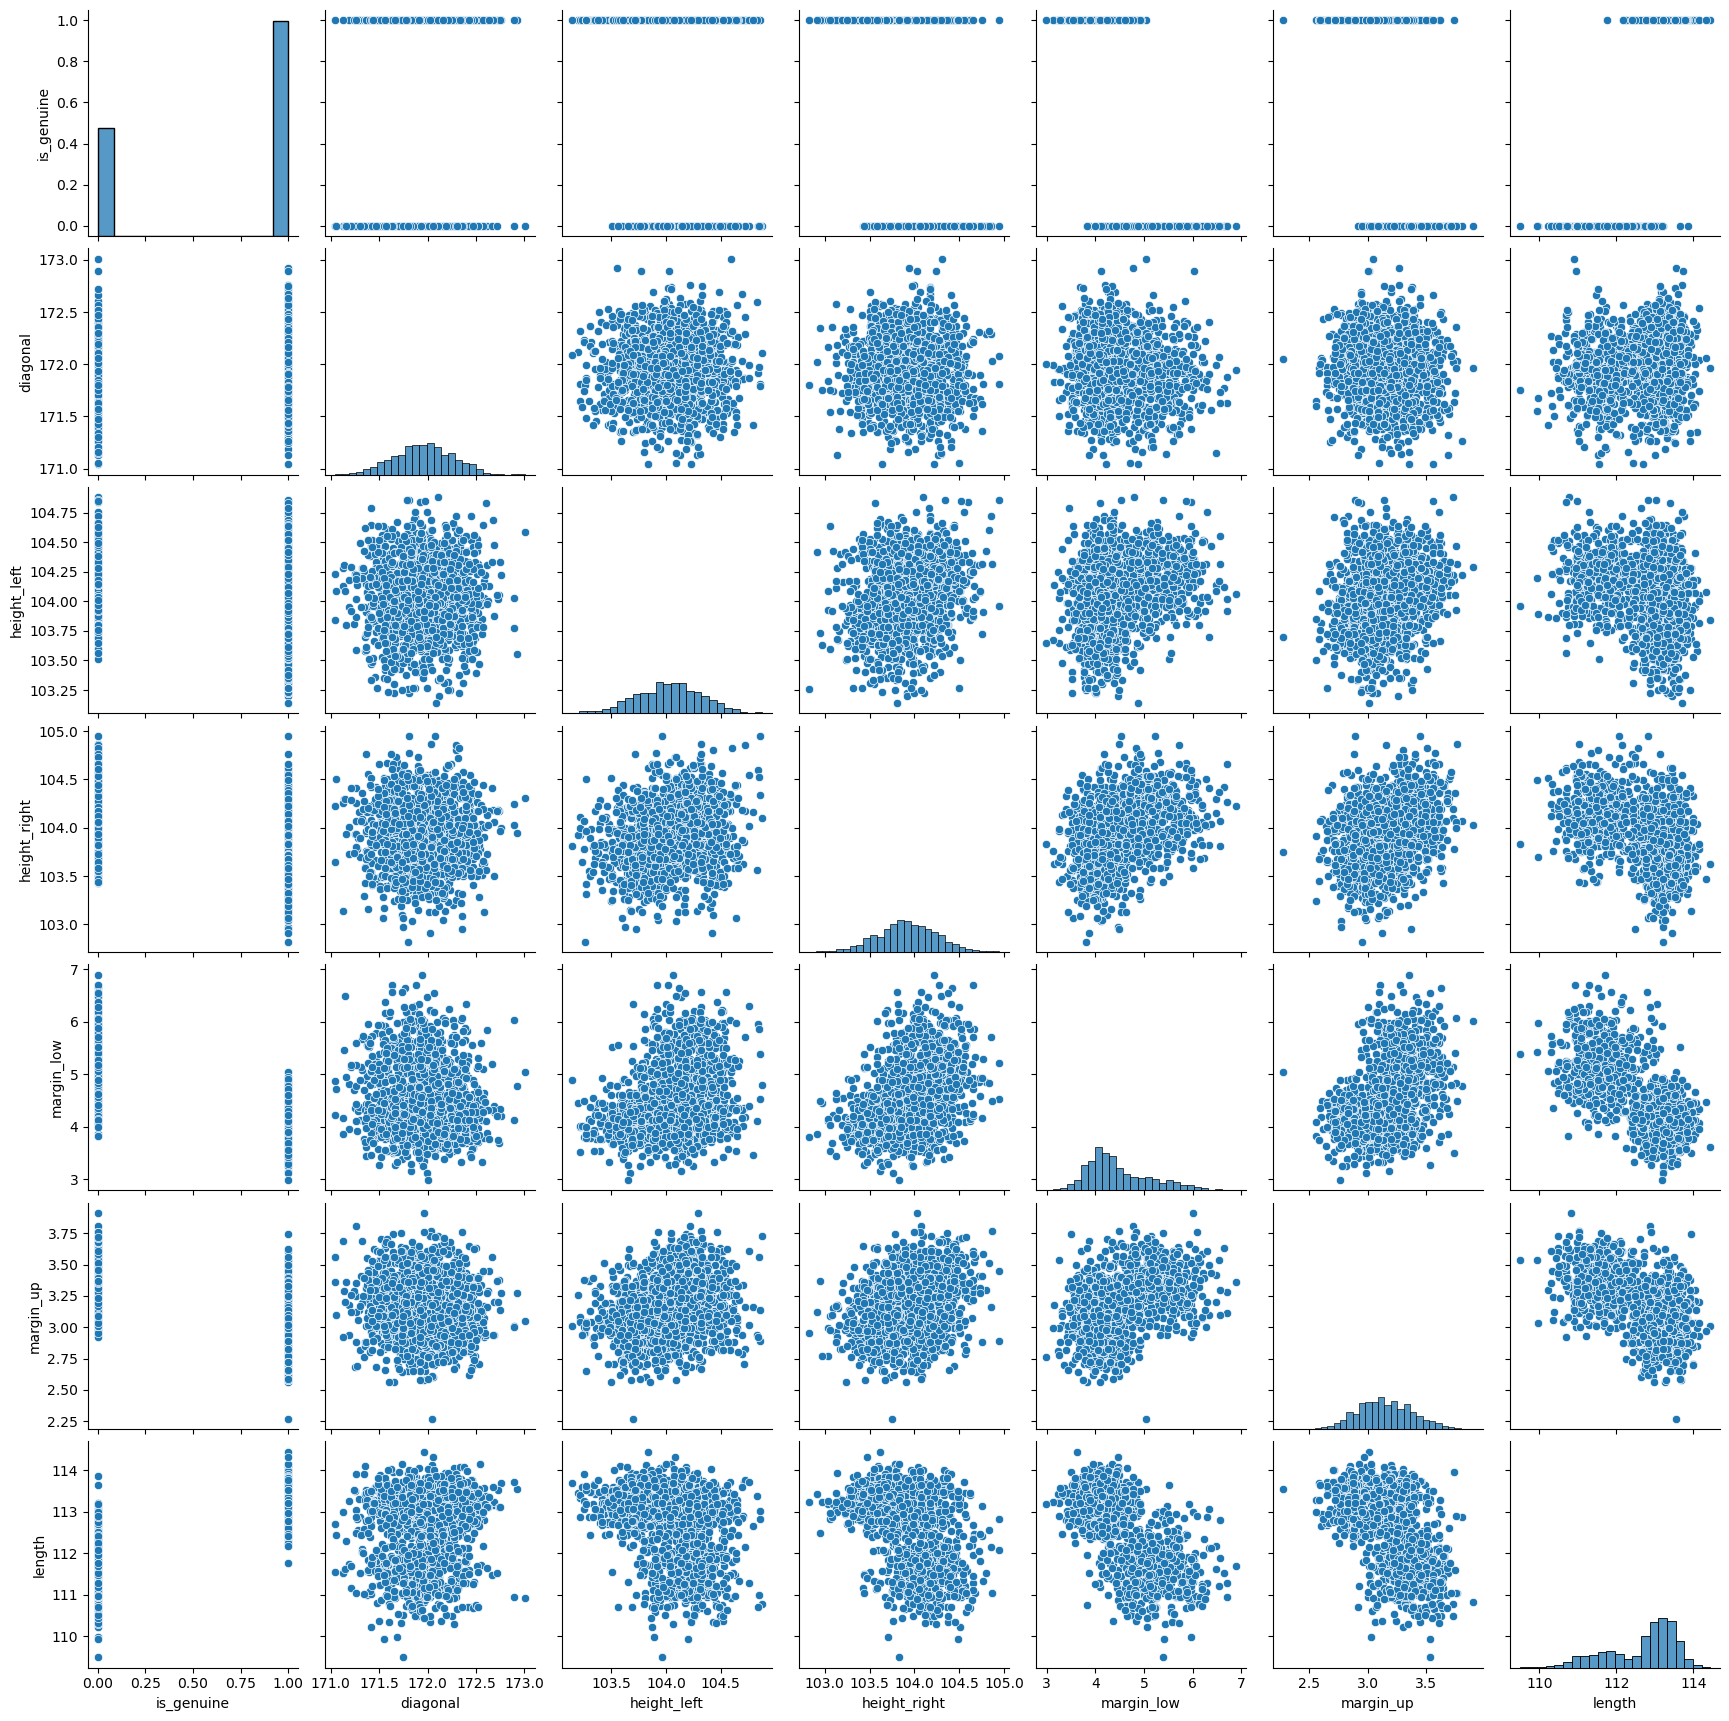

In [37]:
sns.pairplot(data)

<a id='testhyp' ></a>
## Test d'hypothèse<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

On va vérifier si les différences entre les vrais et les faux billets sont significatives pour chaque variable.

On va réaliser un test de student qui va comparer la moyenne des 2 populations.

Les prérequis du test de student sont :
- La normalité de la distribution des 2 groupes.
- L'homogénéité des variances des 2 groupes.

In [38]:
data_true = data[data['is_genuine']==True]
data_false = data[data['is_genuine']==False]

### Normalité des distribution

In [39]:
for col in data.drop(columns='is_genuine').columns:
    print(col)
    print('Vrai billet')
    print(shapiro(data_true[col]))
    print('Faux billet')
    print(shapiro(data_false[col]))
    print('_'*100)

diagonal
Vrai billet
ShapiroResult(statistic=0.9980633854866028, pvalue=0.3102126121520996)
Faux billet
ShapiroResult(statistic=0.9974355697631836, pvalue=0.6387675404548645)
____________________________________________________________________________________________________
height_left
Vrai billet
ShapiroResult(statistic=0.9965806603431702, pvalue=0.028511906042695045)
Faux billet
ShapiroResult(statistic=0.9978764057159424, pvalue=0.7906213998794556)
____________________________________________________________________________________________________
height_right
Vrai billet
ShapiroResult(statistic=0.9985494613647461, pvalue=0.5872448086738586)
Faux billet
ShapiroResult(statistic=0.9979901313781738, pvalue=0.826613187789917)
____________________________________________________________________________________________________
margin_low
Vrai billet
ShapiroResult(statistic=0.9982866048812866, pvalue=0.4238669276237488)
Faux billet
ShapiroResult(statistic=0.9970296025276184, pvalue=0.50074

Toutes les distributions sont considérées normales si on prends un alpha=0.01.

### Homogénéité des variances

Test de Bartlett avec :

    H0 : Les variances des sous groupes sont égales
    H1 : Les variances des sous groupes sont différentes
    
alpha=1%

In [40]:
for col in data.drop(columns='is_genuine').columns:
    print(col)
    print(bartlett(data_true[col], data_false[col]))
    print('_'*100)

diagonal
BartlettResult(statistic=0.2987117108240286, pvalue=0.5846911917435405)
____________________________________________________________________________________________________
height_left
BartlettResult(statistic=53.27625211922919, pvalue=2.8978873571016144e-13)
____________________________________________________________________________________________________
height_right
BartlettResult(statistic=3.542589524124933, pvalue=0.05981201390578732)
____________________________________________________________________________________________________
margin_low
BartlettResult(statistic=216.88739037276582, pvalue=4.31861679806311e-49)
____________________________________________________________________________________________________
margin_up
BartlettResult(statistic=0.6698400851031404, pvalue=0.41310736619306765)
____________________________________________________________________________________________________
length
BartlettResult(statistic=207.23111965352825, pvalue=5.5204655214194

Le test d'homogénéité des variances est passé pour 'diagonal', 'height_right' et 'margin_up'.

On peut uniquement passer le test de student pour ces variables.

### Test de Student

In [41]:
for col in data.drop(columns='is_genuine').columns:
    print(col)
    print(ttest_ind(data_true[col], data_false[col]))
    print('_'*100)

diagonal
Ttest_indResult(statistic=5.184087524514633, pvalue=2.4668667372034535e-07)
____________________________________________________________________________________________________
height_left
Ttest_indResult(statistic=-15.8920858636644, pvalue=1.1269164017693944e-52)
____________________________________________________________________________________________________
height_right
Ttest_indResult(statistic=-21.470310019402618, pvalue=2.2708556903459502e-89)
____________________________________________________________________________________________________
margin_low
Ttest_indResult(statistic=-48.79265591014387, pvalue=8.919896249647e-312)
____________________________________________________________________________________________________
margin_up
Ttest_indResult(statistic=-29.50561631725463, pvalue=3.144530308715909e-151)
____________________________________________________________________________________________________
length
Ttest_indResult(statistic=62.262782927091045, pvalue

On considère les moyennes des groupes (vrais et faux billets) différentes pour toutes les variables.

Mais le test n'est officiellement validé que pour les variables 'diagonal', 'height_right' et 'margin_up'.

### Détermination des valeurs aberrantes

#### Score de Mahalanobis

Le Score de Mahalanobis mesure la distance entre un individu et le centre de gravité de l'ensemble de données en prenant en compte la covariance des variables. Plus le score est élevé plus l'individu est globalement éloigné du reste des données et est un outlier.

Les données doivent être centrées réduites pour calculer ce score.

In [42]:
# centrage et réduction des données
data_scaler = data.copy()
scaler = StandardScaler()
data_scaler['is_genuine'] = data_scaler['is_genuine'].replace([True,False], [1,0])
data_scaler[data_scaler.drop(columns='is_genuine').columns] = scaler.fit_transform(data.drop(columns='is_genuine'))
data_scaler.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651
1,1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666
2,1,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901
3,1,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075
4,1,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750


In [43]:
# calcul du score de Mahalanobis
data_scaler = data_scaler.values

# Calculer la moyenne de chaque variable
mean = np.mean(data_scaler, axis=0)

# Calculer la matrice de covariance
cov = np.cov(data_scaler.T)

# Calculer l'inverse de la matrice de covariance
inv_cov = np.linalg.inv(cov)

# Calculer le score de Mahalanobis pour chaque point
mahalanobis_scores = np.array([mahalanobis(x, mean, inv_cov) for x in data_scaler])

df_mahalanobis_scores = pd.DataFrame(mahalanobis_scores, columns=['mahalanobis_scores'])
df_mahalanobis_scores.sort_values('mahalanobis_scores', ascending=False)

,mahalanobis_scores
1122,5.665974
0,5.383956
1082,5.165134
1329,4.987561
1134,4.986549
...,...
50,0.910003
642,0.894335
656,0.857268
104,0.811379


In [44]:
data3 = data.copy()

data3['mahalanobis_scores'] = df_mahalanobis_scores['mahalanobis_scores']

<Axes: xlabel='mahalanobis_scores', ylabel='Count'>

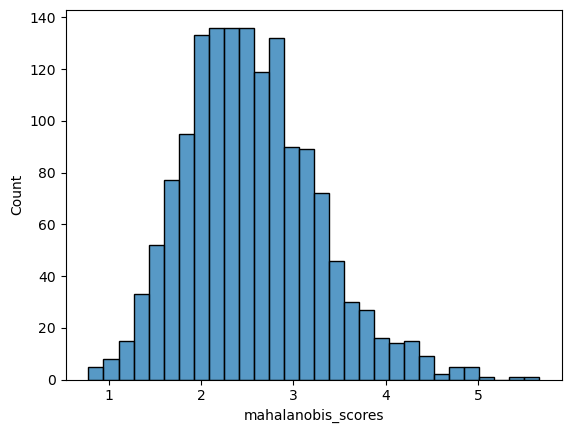

In [45]:
# distribution des scores de mahalanobis
sns.histplot(data3['mahalanobis_scores'])

On pourrait considérer les valeurs supérieurs à 4 comme des valeurs atypiques.

In [46]:
data3[data3['mahalanobis_scores']<4]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,mahalanobis_scores
1,True,171.46,103.36,103.66,3.77,2.99,113.09,2.912170
2,True,172.69,104.48,103.50,4.40,2.94,113.16,3.402952
3,True,171.36,103.91,103.94,3.62,3.01,113.51,2.660107
4,True,171.73,104.28,103.46,4.04,3.48,112.54,3.454499
5,True,172.17,103.74,104.08,4.42,2.95,112.81,2.000679
...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,3.134542
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,2.844104
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,1.885546
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,2.166843


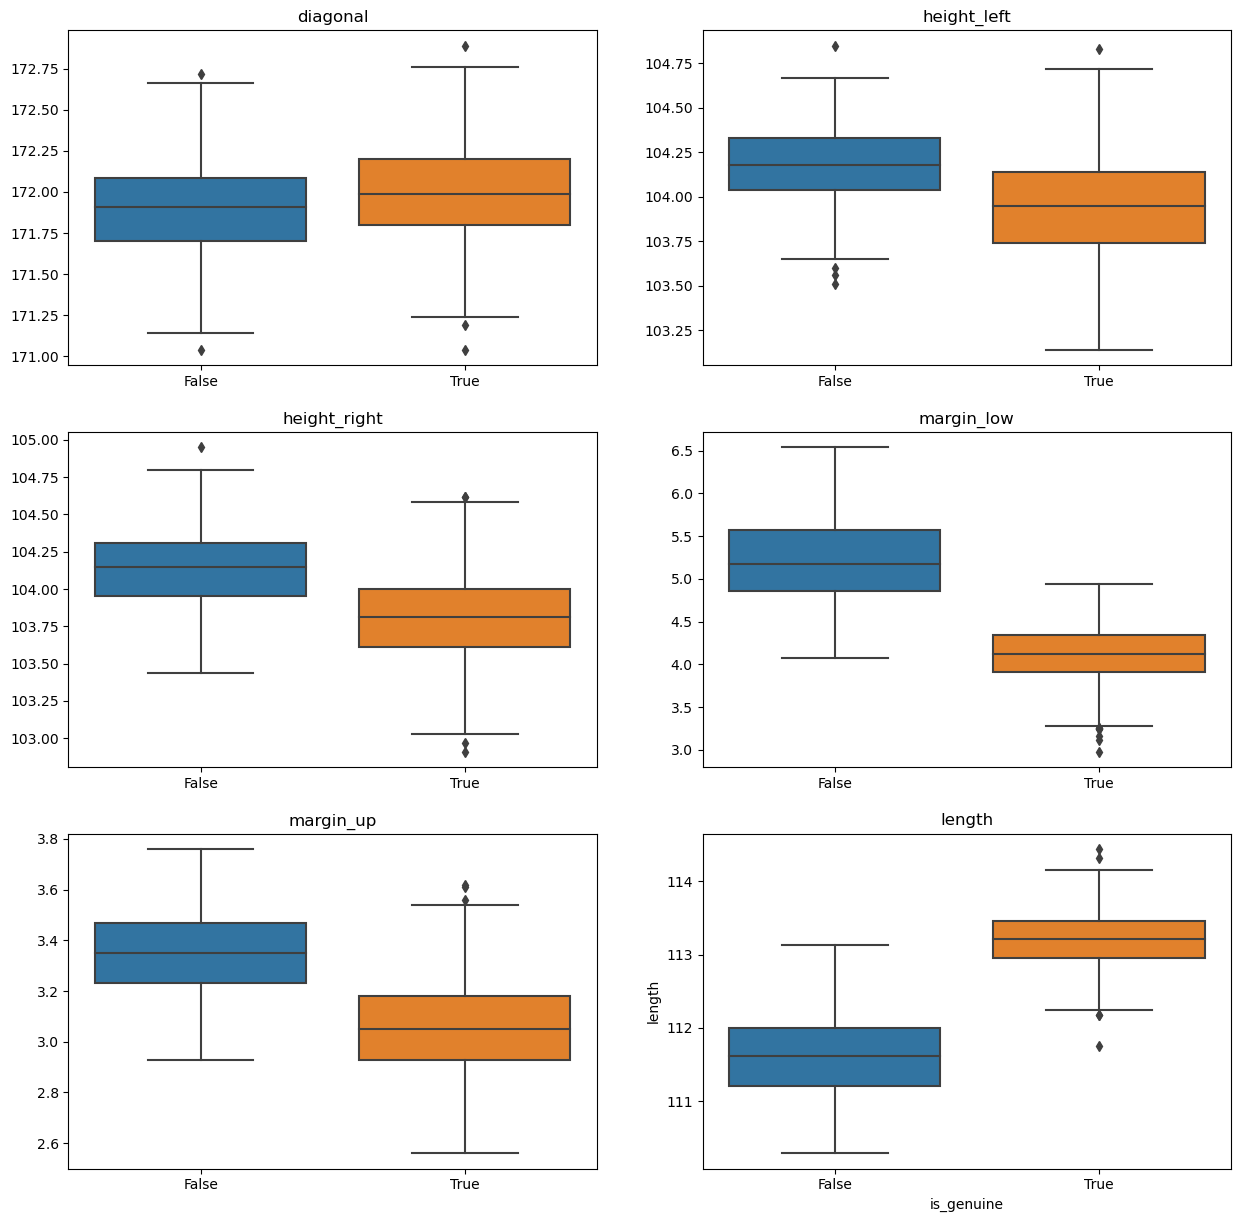

In [47]:
# boites à moustaches en enlevant les observations avec un score de mahalanobis supérieur ou égale à 4

nb_col = data.drop(columns='is_genuine').shape[1]

plt.figure(figsize=(15, 20))

for col, i in zip(data.drop(columns='is_genuine').columns, range(nb_col)):
    plt.xlabel(None)
    plt.ylabel(None)
    plt.subplot(1+nb_col//2, 2, i+1)
    plt.title(col)
    sns.boxplot(data=data3[data3['mahalanobis_scores']<4], y=col, x='is_genuine')

Les valeurs n'étant pas réellement aberrantes, je décide de les garder.

#### Zscore

In [48]:
data_zscore = data.copy()
data_true_zscore = data_true.copy()
data_false_zscore = data_false.copy()

In [49]:
for col in data.drop(columns='is_genuine').columns : 
    data_true_zscore = data_true_zscore[abs(st.zscore(data_true_zscore[col]))<3]
    data_false_zscore = data_false_zscore[abs(st.zscore(data_false_zscore[col]))<3]
    data_zscore = pd.concat((data_true_zscore, data_false_zscore), axis=0)
    print(data_true_zscore.shape)
    print(data_false_zscore.shape)
    print(data_zscore.shape)
    print('_'*100)

(997, 7)
(498, 7)
(1495, 7)
____________________________________________________________________________________________________
(996, 7)
(495, 7)
(1491, 7)
____________________________________________________________________________________________________
(993, 7)
(495, 7)
(1488, 7)
____________________________________________________________________________________________________
(990, 7)
(494, 7)
(1484, 7)
____________________________________________________________________________________________________
(987, 7)
(493, 7)
(1480, 7)
____________________________________________________________________________________________________
(984, 7)
(490, 7)
(1474, 7)
____________________________________________________________________________________________________


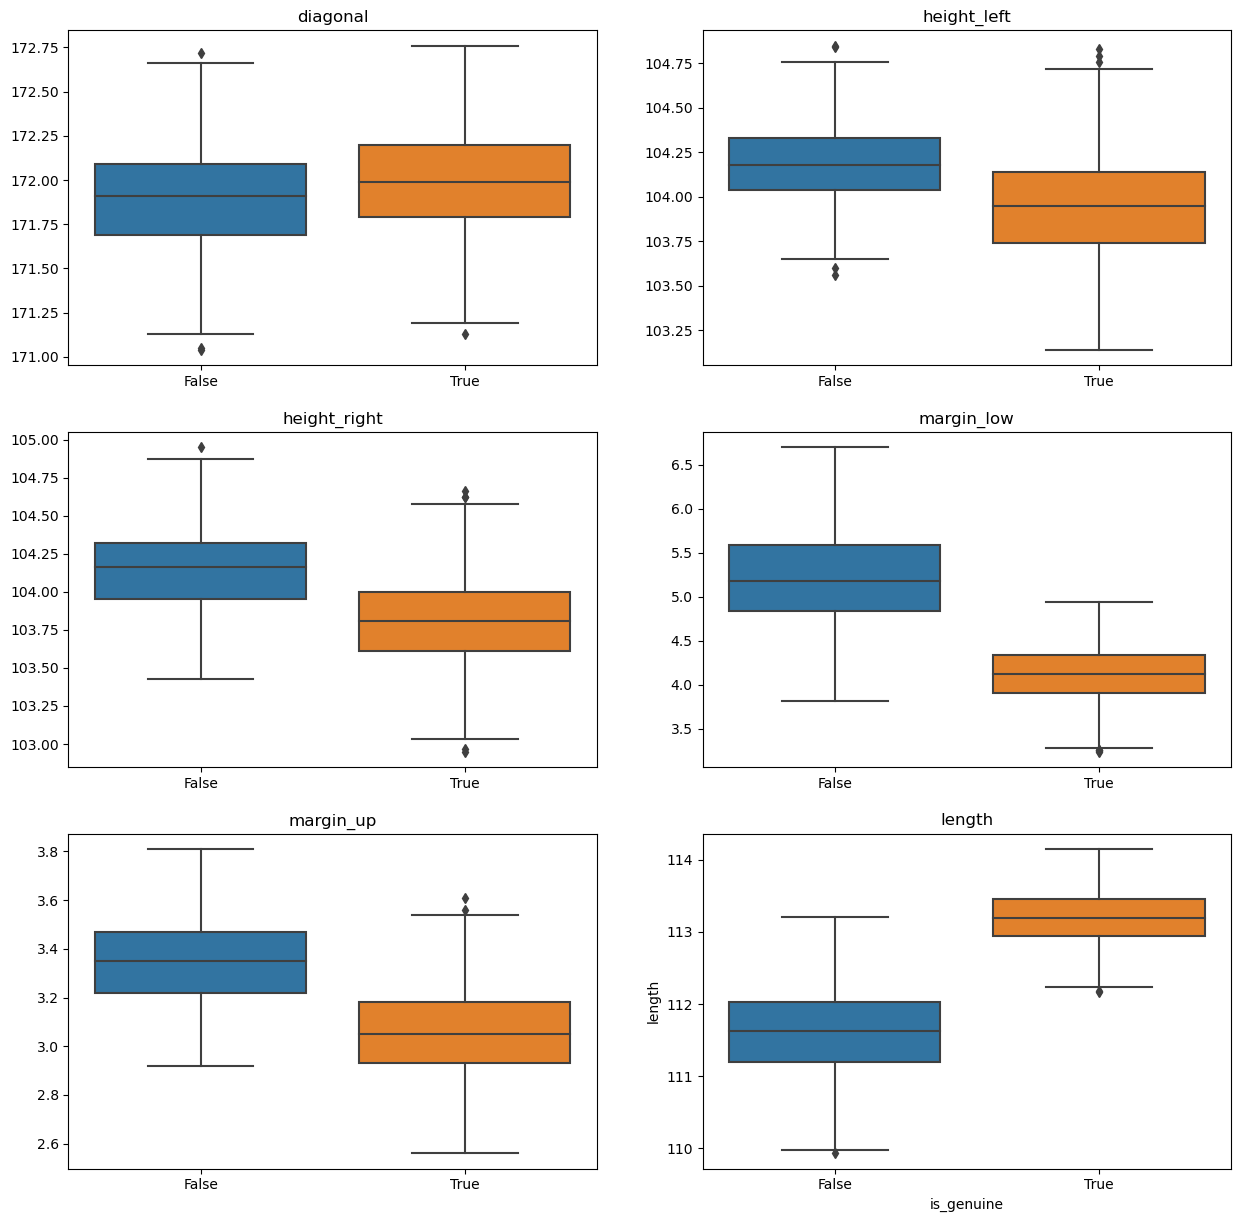

In [50]:
nb_col = data.drop(columns='is_genuine').shape[1]

plt.figure(figsize=(15, 20))

for col, i in zip(data.drop(columns='is_genuine').columns, range(nb_col)):
    plt.xlabel(None)
    plt.ylabel(None)
    plt.subplot(1+nb_col//2, 2, i+1)
    plt.title(col)
    sns.boxplot(data=data_zscore, y=col, x='is_genuine')

<a id='modelisation' ></a>
# Modélisation<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

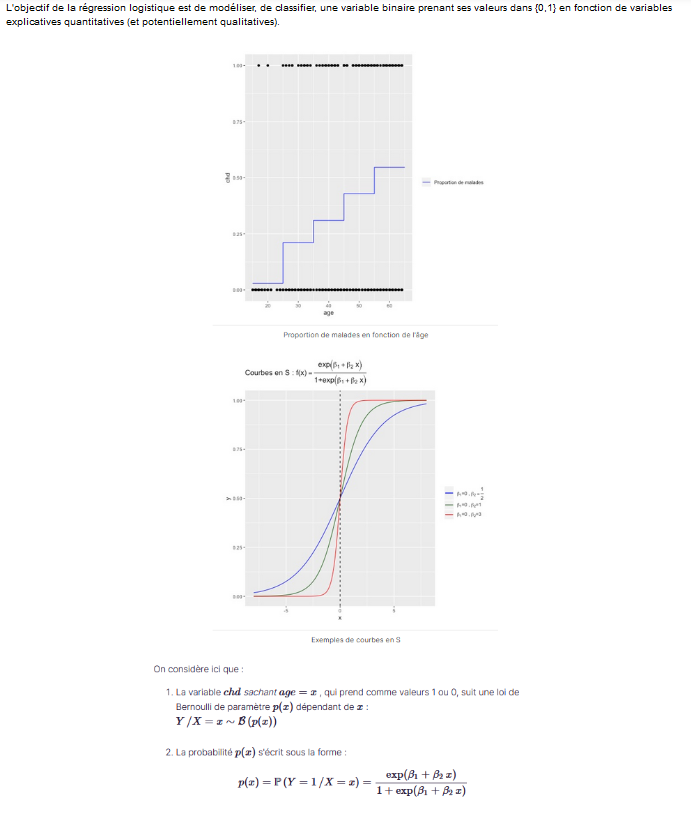

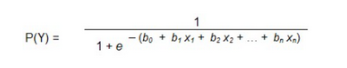

En fonction des valeurs des variabes explicatives, on applique on probabilité à la variable cible d'être égale à 0 ou 1.

<a id='reglogsklearn' ></a>
## Régression Logistique avec sklearn<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [51]:
data['is_genuine'] = data['is_genuine'].replace([True, False], [1,0])

In [52]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [53]:
data['is_genuine'].value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

In [54]:
# cible et features, features standardisées pour afficher la courbe d'apprentissage
X = StandardScaler().fit_transform(data.drop(columns='is_genuine'))
y = data['is_genuine']

In [55]:
# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [56]:
print(y_train.value_counts())
print(y_test.value_counts())

1    798
0    402
Name: is_genuine, dtype: int64
1    202
0     98
Name: is_genuine, dtype: int64


In [57]:
# creation du modèle de régression logistique
model = LogisticRegression()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9966666666666667

### Evaluation

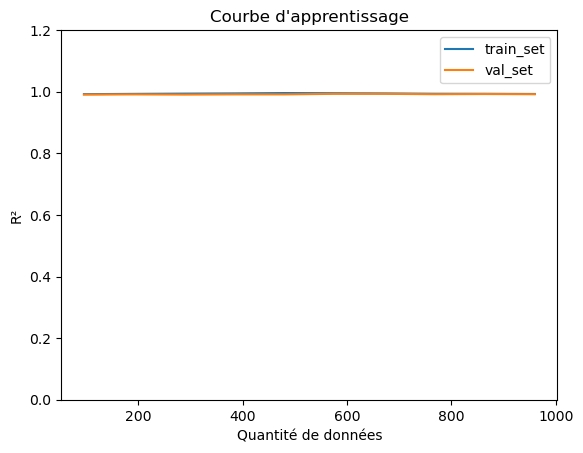

In [58]:
# courbe d'apprentissage du meilleur estimateur, on utilise le score F1
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='f1')

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

Les jeux d'entrainement et de validation ont un R² similaire proche de 1.  
Le modèle n'est donc pas en sur-apprentissage et est capable de généraliser.

In [59]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,0,202


In [60]:
# vérification du faux positif
test_pred = pd.DataFrame(y_test)

test_pred['y_pred'] = y_pred

test_pred.loc[(test_pred['is_genuine']==0)&(test_pred['y_pred']==1)]

,is_genuine,y_pred
1407,0,1


In [61]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



#### Courbe ROC

La courbe ROC, ou Receiver Operating Characteristic curve en anglais, est un outil graphique largement utilisé en statistiques et en apprentissage automatique pour évaluer les performances d'un modèle de classification binaire, tel qu'un modèle de machine learning qui doit décider entre deux classes, comme "positif" et "négatif". La courbe ROC permet de visualiser la capacité d'un modèle à discriminer entre ces deux classes en fonction de différents seuils de classification.

La courbe ROC représente les vrais bien classés (sensibilité) en fonction des faux mal classés (anti spécificité) en fonction de différentes valeurs de seuils.

In [62]:
# probabilité pour chaque observation de X_test d'appartenir à la classe 1
y_pred_prob = model.predict_proba(X_test)[:,1]

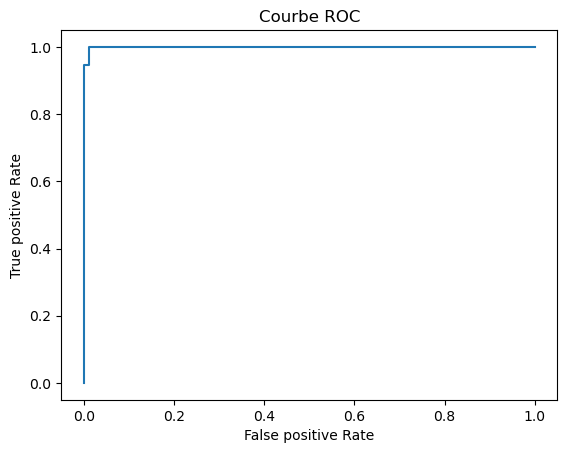

In [63]:
# courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.title("Courbe ROC")
plt.xlabel("False positive Rate")
plt.ylabel("True positive Rate")
plt.plot(fpr, tpr);

In [64]:
# AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"L'AUC score est de {auc_score}, cet indicateur correspond à l'aire, plus l'aire est élevé, plus le modèle est qualitatif.")

L'AUC score est de 0.9994443321883208, cet indicateur correspond à l'aire, plus l'aire est élevé, plus le modèle est qualitatif.


In [65]:
# détermination du meilleur seuil

best = tpr - fpr
best_thresholds = thresholds[np.argmax(tpr - fpr)]

print(f"On pourrait placer le seuil à {best_thresholds} pour définir les classes lors des prédictions.")

On pourrait placer le seuil à 0.6322587970007553 pour définir les classes lors des prédictions.


#### Incidence du seuil sur la sensibilité et la spécificité

Pour rappel, la sensibilité représente les vrais billets bien classés (tp/(tp+fn)).  
Et la spécificité représente les faux billets bien classés (tn/(tn+fp)).

In [66]:
seuils = np.linspace(0, 1, 20)
anti_specificitys = []
sensitivitys = []

for seuil in seuils :
    
    y_pred = y_pred_prob >= seuil
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    confusion_matrice = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                    columns = ['Prédit Faux', 'Prédit Vrai'], index = ['Faux', 'Vrai'])
    
    # metrique de classification des faux billets, taux de faux negatifs
    # probabilité lié aux vrais négatifs
    specificity = tn/(tn+fp)
    # taux de faux billets mal classés, taux de faux positifs
    anti_specificity = 1 - specificity

    # metrique de classification des vrais billets
    # probabilité lié aux vrais positifs
    sensitivity = tp/(tp+fn)
    
    anti_specificitys.append(anti_specificity)
    sensitivitys.append(sensitivity)

In [67]:
tableau_seuil = pd.DataFrame([seuils, sensitivitys, anti_specificitys],
            index=['Seuil', 'Taux de vrais positifs', 'Taux de faux positifs']).T
tableau_seuil

,Seuil,Taux de vrais positifs,Taux de faux positifs
0,0.000000,1.000000,1.000000
1,0.052632,1.000000,0.071429
2,0.105263,1.000000,0.051020
3,0.157895,1.000000,0.040816
4,0.210526,1.000000,0.030612
5,0.263158,1.000000,0.020408
6,0.315789,1.000000,0.020408
7,0.368421,1.000000,0.020408
8,0.421053,1.000000,0.010204
9,0.473684,1.000000,0.010204


Les seuils entre 0.368 et 0.684 offres les meilleurs résultats.  
Le taux de vrais positifs (1.0) est maximum tandis que le taux de faux positifs est minimum (0.1).

Le taux initial à 0.5 est donc adapté.

<a id='reglogstatmodel' ></a>
## Régression Logistique avec statmodels<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [68]:
# df pour garder le nom des colonnes
X_stat = pd.DataFrame(data.drop(columns='is_genuine'), columns=data.drop(columns='is_genuine').columns)

# ajout de la constante
X_stat = sm.add_constant(X_stat)

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=1)

model = sm.Logit(y_train, X_train)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.030424
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.9523
Time:                        14:13:42   Log-Likelihood:                -36.509
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                9.132e-312
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -215.0874    261.241     -0.823      0.410    -727.111     296.936
diagonal         0.1374      1.174      0.117      0.907      -2.163       2.438
height_left     -1.7707      1.158     -1.529      0.126      -4.040       0.499
height_right    -1.9413      1.077     -1.803      0.071      -4.051       0.169
margin_low      -5.7866      1.017     -5.691      0.000      -7.779      -3.794
margin_up      -10.3765      2.326     -4.461      0.000     -14.935      -5.818
length           5.6649      0.887      6.390      0.000       3.927       7.402
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Certaines variables ne sont pas significatives pour le modèle, on va enlever la variable qui est la moins significative, ici 'diagonal', avec sa p-value de 0.907, puis relancer le modèle et vérifier la significativité des variable restante jusqu'à qu'elles soient toutes significatives.

In [69]:
# df pour garder le nom des colonnes
X_stat = pd.DataFrame(data.drop(columns=['is_genuine', 'diagonal']), columns=data.drop(columns=['is_genuine', 'diagonal']).columns)

# ajout de la constante
X_stat = sm.add_constant(X_stat)

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=1)

model = sm.Logit(y_train, X_train)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.030430
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.9523
Time:                        14:13:42   Log-Likelihood:                -36.516
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -191.3113    163.815     -1.168      0.243    -512.383     129.761
height_left     -1.7684      1.158     -1.527      0.127      -4.038       0.501
height_right    -1.9583      1.064     -1.841      0.066      -4.043       0.127
margin_low      -5.8274      0.961     -6.064      0.000      -7.711      -3.944
margin_up      -10.4045      2.318     -4.488      0.000     -14.949      -5.860
length           5.6796      0.881      6.446      0.000       3.953       7.407
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Ici, on enlève 'height_left' avec sa p-value de 0.127 > 0.05 si on prend un seuil de significativité à 0.05 (norme à 0.05 ou 0.01).

In [70]:
# df pour garder le nom des colonnes
X_stat = pd.DataFrame(data.drop(columns=['is_genuine', 'diagonal', 'height_left']), columns=data.drop(columns=['is_genuine', 'diagonal', 'height_left']).columns)

# ajout de la constante
X_stat = sm.add_constant(X_stat)

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_stat, y, test_size=0.2, random_state=1)

model = sm.Logit(y_train, X_train)

results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.031437
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.9507
Time:                        14:13:42   Log-Likelihood:                -37.724
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -326.1464    144.416     -2.258      0.024    -609.197     -43.096
height_right    -2.4191      1.076     -2.249      0.025      -4.528      -0.311
margin_low      -6.0344      0.968     -6.236      0.000      -7.931      -4.138
margin_up      -10.4453      2.286     -4.569      0.000     -14.926      -5.965
length           5.6778      0.857      6.621      0.000       3.997       7.358
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

On considère ici que toutes les variables sont significatives pour le modèle.

Il est possible d'automatiser le choix des variables pour le modèle avec l'algorithme de 'backward_selected'.

In [71]:
# VIF
vif = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif = pd.DataFrame(vif, index=X_train.columns, columns=['VIF'])
df_vif

,VIF
const,187569.205220
height_right,1.244908
margin_low,1.958859
margin_up,1.372698
length,2.135762


In [72]:
# prédiction proba
y_pred_prob = results.predict(X_test)

In [73]:
# observations classées de manière moins évidente mais bien classées tout de même
y_pred_prob[(y_pred_prob>0.1)&(y_pred_prob<0.9)]

985     0.759878
1472    0.160332
669     0.706214
623     0.866412
1084    0.342540
525     0.878138
159     0.894271
dtype: float64

In [74]:
# qualifié vrai à 96% alors qu'il était faux
y_pred_prob[y_pred_prob.index == 1407]

1407    0.964138
dtype: float64

In [75]:
# prédiction
y_pred = results.predict(X_test).round().astype('int')

In [76]:
test_pred = pd.concat((y_test, y_pred), axis=1)

crosstab = pd.crosstab(test_pred['is_genuine'], test_pred[0])

crosstab.index = ['Faux', 'Vrai']
crosstab.columns = ['Prédit Faux', 'Prédit Vrai']

crosstab

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,0,202


In [77]:
test_pred.loc[(test_pred['is_genuine']==0)&(test_pred[0]==1)]

,is_genuine,0
1407,0,1


In [78]:
y_test.value_counts()

1    202
0     98
Name: is_genuine, dtype: int64

### Pourquoi 1407 est toujours prédit vrai alors qu'il est faux ?

In [79]:
for col in data.drop(columns='is_genuine').columns : 
    print(col)
    print('1407 :', data[col][1407])
    print('moyenne true :', data_true[col].mean())
    print('moyenne false :', data_false[col].mean())
    print('_'*100)

diagonal
1407 : 172.02
moyenne true : 171.98708000000002
moyenne false : 171.90115999999998
____________________________________________________________________________________________________
height_left
1407 : 103.99
moyenne true : 103.94913000000001
moyenne false : 104.19033999999999
____________________________________________________________________________________________________
height_right
1407 : 104.28
moyenne true : 103.80865000000001
moyenne false : 104.14362
____________________________________________________________________________________________________
margin_low
1407 : 4.22
moyenne true : 4.118173525936517
moyenne false : 5.214078882087355
____________________________________________________________________________________________________
margin_up
1407 : 2.98
moyenne true : 3.0521299999999996
moyenne false : 3.3501600000000002
____________________________________________________________________________________________________
length
1407 : 112.42
moyenne true : 113.

diagonal
1407 : 172.02
moyenne true : 171.98708000000002
moyenne false : 171.90115999999998


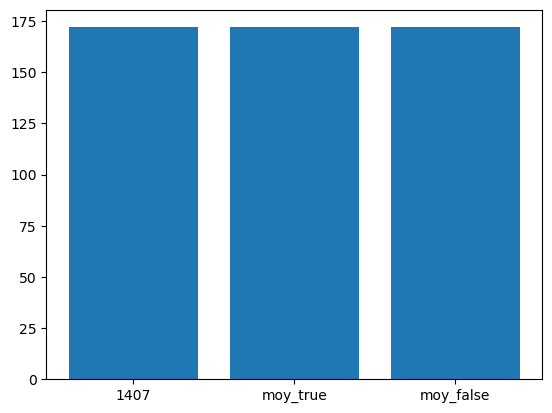

____________________________________________________________________________________________________
height_left
1407 : 103.99
moyenne true : 103.94913000000001
moyenne false : 104.19033999999999


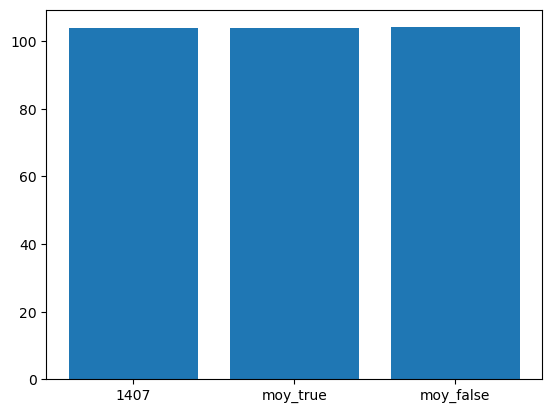

____________________________________________________________________________________________________
height_right
1407 : 104.28
moyenne true : 103.80865000000001
moyenne false : 104.14362


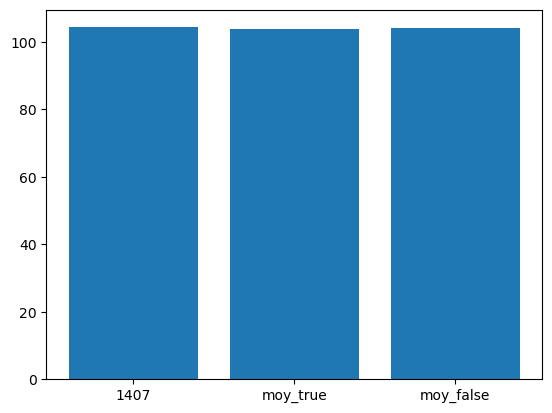

____________________________________________________________________________________________________
margin_low
1407 : 4.22
moyenne true : 4.118173525936517
moyenne false : 5.214078882087355


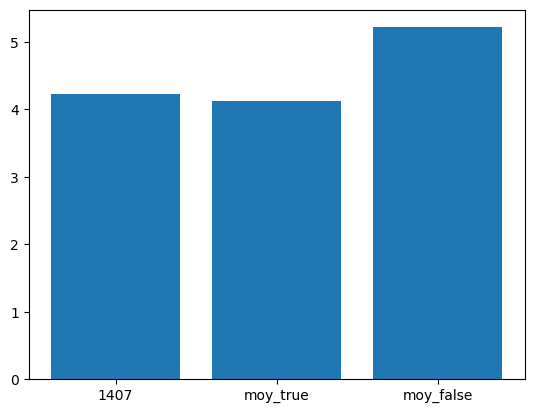

____________________________________________________________________________________________________
margin_up
1407 : 2.98
moyenne true : 3.0521299999999996
moyenne false : 3.3501600000000002


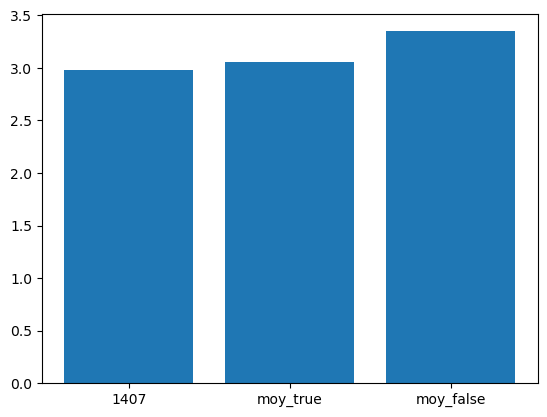

____________________________________________________________________________________________________
length
1407 : 112.42
moyenne true : 113.20242999999999
moyenne false : 111.63064000000001


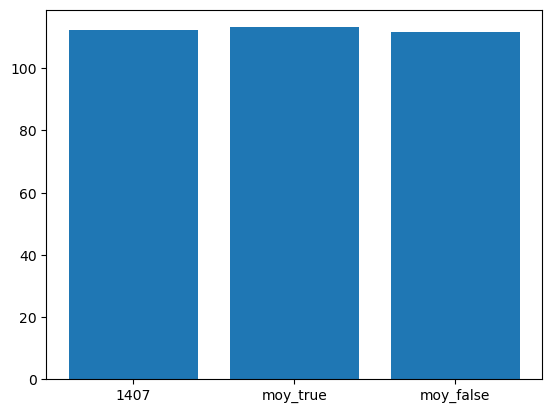

____________________________________________________________________________________________________


In [80]:
for col in data.drop(columns='is_genuine').columns : 
    print(col)
    print('1407 :', data[col][1407])
    print('moyenne true :', data_true[col].mean())
    print('moyenne false :', data_false[col].mean())
    plt.bar(x=['1407', 'moy_true', 'moy_false'], height=[data[col][1407], data_true[col].mean(), data_false[col].mean()])
    plt.show()
    print('_'*100)

<a id='kmeans' ></a>
## Kmeans<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [81]:
data2 = data.copy()
data2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [82]:
# création de l'estimateur
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=20)

kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto', random_state=20)

In [83]:
# coordonnées des centroides

centroides = kmeans.cluster_centers_

# clusters de l'echantillon

data2['clusters_kmeans'] = kmeans.labels_

In [84]:
# encodage de la variable binaire
data2['is_genuine'] = data2['is_genuine'].replace([True, False], [1,0])

In [85]:
data2['is_genuine'].value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

In [86]:
# creation de la matrice de confusion avec la méthode du kmeans
crosstab = pd.crosstab(data2['clusters_kmeans'], data2['is_genuine'])
crosstab.index = ['Faux', 'Vrai']
crosstab.columns = ['Prédit Faux', 'Prédit Vrai']
crosstab

,Prédit Faux,Prédit Vrai
Faux,487,10
Vrai,13,990


La Régression Logistique donne de meilleur résultat

In [87]:
confusion_matrix(data2['is_genuine'], data2['clusters_kmeans'])

array([[487,  13],
       [ 10, 990]], dtype=int64)

In [88]:
print(classification_report(data2['is_genuine'], data2['clusters_kmeans']))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       500
           1       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



<a id='evalfinal' ></a>
## Evaluation finale<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [89]:
data_prod = pd.read_csv(folder+'billets_production.csv', delimiter=',')
data_prod.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [90]:
# data_prod test
data_prod_pred = data_prod.copy()

In [91]:
# mise au format de mon modèle final

# ajout de la constante
X_eval = sm.add_constant(data_prod_pred)

# mise au format du modèle en gardant les colonnes significatives utilisées pour le modèle final
X_eval = X_eval[results.model.exog_names]
X_eval

,const,height_right,margin_low,margin_up,length
0,1.0,103.54,5.21,3.30,111.42
1,1.0,104.13,6.00,3.31,112.09
2,1.0,104.29,4.99,3.39,111.57
3,1.0,104.34,4.44,3.03,113.20
4,1.0,103.56,3.77,3.16,113.33


In [92]:
# prédiction des 5 billets en terme de probabilité
results.predict(X_eval)

0    0.000050
1    0.000004
2    0.000028
3    0.996748
4    0.999984
dtype: float64

In [93]:
# prédiction de la nature des billets (vrai ou faux) en fonction de leurs caractéristiques
data_prod_pred['prediction_billet'] = results.predict(X_eval).round().astype('int').replace([0,1], ['Faux', 'Vrai'])
data_prod_pred

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction_billet
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai


In [94]:
# message à afficher 

for billet, prediction in zip(data_prod_pred['id'], data_prod_pred['prediction_billet']):
    if prediction == 'Vrai':
        print(f"C'est bon, le billet {billet} est un {prediction} !")
    if prediction == 'Faux':
        print(f"Attention, le billet {billet} est un {prediction} !")

Attention, le billet A_1 est un Faux !
Attention, le billet A_2 est un Faux !
Attention, le billet A_3 est un Faux !
C'est bon, le billet A_4 est un Vrai !
C'est bon, le billet A_5 est un Vrai !


<a id='fonctpred' ></a>
### Fonction de prédiction<a href="#sommaire" style="font-size : 10px ; padding-left:10px">Retour Sommaire</a>

In [95]:
def prediction(data_prod):
    
    # mise au format de mon modèle final
    
    data_prod_pred = data_prod.copy()

    # ajout de la constante
    X_eval = sm.add_constant(data_prod_pred)

    # mise au format du modèle en gardant les colonnes significatives utilisées pour le modèle final
    X_eval = X_eval[results.model.exog_names]
    
    # prédiction de la nature des billets (vrai ou faux) en fonction de leurs caractéristiques
    data_prod_pred['prediction_billet'] = results.predict(X_eval).round().astype('int').replace([0,1], ['Faux', 'Vrai'])
    
    # message à afficher 
    
    for billet, prediction in zip(data_prod_pred['id'], data_prod_pred['prediction_billet']):
        if prediction == 'Vrai':
            print(f"C'est bon, le billet {billet} est un {prediction} !")
        if prediction == 'Faux':
            print(f"Attention, le billet {billet} est un {prediction} !")    
            
    return data_prod_pred

In [96]:
prediction(data_prod)

Attention, le billet A_1 est un Faux !
Attention, le billet A_2 est un Faux !
Attention, le billet A_3 est un Faux !
C'est bon, le billet A_4 est un Vrai !
C'est bon, le billet A_5 est un Vrai !


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction_billet
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai


In [97]:
data_test = pd.read_csv(folder+"billets_test.csv")

In [98]:
prediction(data_test)

C'est bon, le billet B_1 est un Vrai !
Attention, le billet B_2 est un Faux !
C'est bon, le billet B_3 est un Vrai !
Attention, le billet B_4 est un Faux !
Attention, le billet B_5 est un Faux !


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction_billet
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,Vrai
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,Faux
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,Vrai
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,Faux
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,Faux


# Bonus : test d'autres modèles

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

## KNN

In [100]:
# cible et features, features standardisées pour afficher la courbe d'apprentissage
X = data.drop(columns='is_genuine')
y = data['is_genuine']

# creation des jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [101]:
# creation du modèle de régression logistique
scores = []

for k in [5, 10, 15, 20, 30, 40]:
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    
    scores.append(score)

In [102]:
scores

[0.9966666666666667,
 0.9966666666666667,
 0.9966666666666667,
 0.9966666666666667,
 0.9966666666666667,
 0.9933333333333333]

In [103]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,1,201


## RandomForest

In [104]:
# creation du modèle de régression logistique
model = RandomForestClassifier()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9933333333333333

In [105]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,97,1
Vrai,1,201


## SVC

In [106]:
# creation du modèle de SVM
model = LinearSVC()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.91

In [107]:
y_pred = model.predict(X_test)
# matrice de confusion
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Prédit Faux', 'Prédit Vrai'],
             index=['Faux', 'Vrai'])

,Prédit Faux,Prédit Vrai
Faux,71,27
Vrai,0,202
